In [1]:
import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as signal
from pathlib import Path
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.signal import medfilt
from scipy.signal import sosfiltfilt, butter


import sys
sys.path.append("../src")
from conversion_mat_to_py import mat2dict, pretty_dict, matobj2dict, dict2ntuple
from sources_cv2 import defineStartEnd, count_frames
from save_datas import save_data
from data_conversions import acc_to_angle


# Definindo as funções utilizadas 

In [2]:
def name_data(voluntary, key):
    
    data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

    if key == 'S1_Synched':
        name = 'S1'
        sincro = '_Synched'
    
    elif key == 'S2_Synched':
        name = 'S2'
        sincro = '_Synched'

    else:
        name = key
        sincro = ''

    arquivo = name + '_Subject_' + voluntary + sincro + '_Sit_and_Stand.csv'
    
    return arquivo, name, sincro

In [3]:
def spectrum_periodogram_complete(data, freq_amostragem, grafico = 'pot'):
    
    ''' Entrada: Dados com todos os sensores np.shape([:,0:27]) '''
    ''' Entrada: tipo de gráfico pot(somente o da densidade de potência), log(gráfico de densidade em log)'''
    '''          pot_log(Os dois gráficos). Por padrão será apenas o gráfico normal '''
    ''' Saídas: Gráficos de Densidade Espectral de Potência '''
    
    eixos = ['eixo x', 'eixo y', 'eixo z']
    sensors_names = ['Hip', 'RightUpLeg', 'LeftUpLeg', 'Head', 'Neck', 'Spine3', 'Spine2', 'Spine1', 'Spine']
    

    if grafico == 'pot':
        for k in range(len(sensors_names)):
            for i in range(len(eixos)):
                f, Pper_spec = signal.periodogram(data.iloc[:,k*3+i].values, freq_amostragem, 'flattop', scaling='spectrum')
                plt.plot(f, Pper_spec, label = eixos[i])
            plt.legend()
            plt.title(sensors_names[k])
            plt.xlabel('Frequência [Hz]')
            plt.ylabel('Densidade Espectral de Potência')
            plt.grid()
            plt.show()
            i = 0
        
    if grafico == 'log':
        for k in range(len(sensors_names)):
            for i in range(len(eixos)):
                f, Pper_spec = signal.periodogram(data.iloc[:,k*3+i].values, freq_amostragem, 'flattop', scaling='spectrum')
                plt.semilogy(f, Pper_spec, label = eixos[i])
            plt.legend()
            plt.title(sensors_names[k])
            plt.xlabel('Frequência [Hz]')
            plt.ylabel('Densidade Espectral de Potência')
            plt.grid()
            plt.show()
            i = 0
            
    if grafico == 'pot_log':
        for k in range(len(sensors_names)):
            for i in range(len(eixos)):
                f, Pper_spec = signal.periodogram(data.iloc[:,k*3+i].values, freq_amostragem, 'flattop', scaling='spectrum')
                plt.semilogy(f, Pper_spec, label = eixos[i])
            plt.legend()
            plt.title(sensors_names[k])
            plt.xlabel('Frequência [Hz]')
            plt.ylabel('Densidade Espectral de Potência')
            plt.grid()
            plt.show()
            i = 0
            for j in range(len(eixos)):
                f, Pper_spec = signal.periodogram(data.iloc[:,k*3+j].values, freq_amostragem, 'flattop', scaling='spectrum')
                plt.plot(f, Pper_spec, label = eixos[j])
            plt.legend()
            plt.title(sensors_names[k])
            plt.xlabel('Frequência [Hz]')
            plt.ylabel('Densidade Espectral de Potência')
            plt.grid()
            plt.show()
            i = 0
        
    

In [4]:
def spectrum_periodogram(data, freq_amostragem, title = 'Sem Título'):
    eixos = ['eixo x', 'eixo y', 'eixo z']
    for i in range(len(eixos)):
        f, Pper_spec = signal.periodogram(data[:,i], freq_amostragem, 'flattop', scaling='spectrum')
        plt.plot(f, Pper_spec, label = eixos[i])
    plt.legend()
    plt.title(title)
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Densidade Espectral de Potência')
    plt.grid()
    plt.show()
    i = 0
    
    for i in range(len(eixos)):
        f, Pper_spec = signal.periodogram(data[:,i], freq_amostragem, 'flattop', scaling='spectrum')
        plt.semilogy(f, Pper_spec, label = eixos[i])
    plt.legend()
    plt.title(title)
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Densidade Espectral de Potência')
    plt.grid()
    plt.show()
    i = 0

In [5]:
def filter_butter(data, ordem, freq_corte, freq_amostragem):
    ''' Entrada: Dados que serão filtrados - shape(n,3)'''
    ''' Entrada: Ordem do filtro'''
    ''' Entrada: Frequência de corte do filtro'''
    ''' Entrada: Frequência de amostragem do filtro'''
    ''' Saída: Dados filtrados - shape(n,3)'''
    
    # Criar o filtro
    create_filter = signal.butter(ordem, freq_corte, btype='low', fs=freq_amostragem, output='sos')
    
    # Criar a variável que irá receber os dados filtrados
    data_filter = np.zeros(data.shape)
    
    # Aplicar o filtro
    data_filter[:,0] = signal.sosfiltfilt(create_filter, data[:,0])
    data_filter[:,1] = signal.sosfiltfilt(create_filter, data[:,1])
    data_filter[:,2] = signal.sosfiltfilt(create_filter, data[:,2])
    
    return data_filter  

In [6]:
def plot_filter_butter(ordem, freq_corte):
    b, a = signal.butter(ordem, freq_corte, 'low', analog=True)
    w, h = signal.freqs(b, a)
    plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.title('Resposta em frequência do filtro Butterworth')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(100, color='green') # cutoff frequency
    plt.show()

In [7]:
def plot_comp_filter(t, data, data_filter, title = 'Sem Título'):
    plt.figure(figsize=[15,8])
    plt.subplot(111)

    plt.plot(t, data_filter, label = 'Com filtro')
    plt.plot(t, data, label = 'Sem filtro')
    plt.legend()
    plt.title(title)
    plt.grid()
    plt.show()

# -> Escolher os voluntários e chaves

* Voluntário => 1 até 90
* Chaves => 'S1_Synched', 'S2_Synched', 'I1', 'I2', 'S1', 'S2'

In [8]:
''' Alterar o número do voluntário  1 '''

voluntary_1 = 5
key_1 = 'S1_Synched'

voluntary_1 = str(voluntary_1)

''' Alterar o número do voluntário 2'''

voluntary_2 = 13
key_2 = 'S1_Synched'

voluntary_2 = str(voluntary_2)

''' Alterar o número do voluntário 3'''

voluntary_3 = 18
key_3 = 'S1_Synched'

voluntary_3 = str(voluntary_3)

''' Alterar o número do voluntário 4'''

voluntary_4 = 21
key_4 = 'S1_Synched'

voluntary_4 = str(voluntary_4)

''' Alterar o número do voluntário 5'''

voluntary_5 = 23
key_5 = 'S1_Synched'

voluntary_5 = str(voluntary_5)


In [9]:
archive_1, name_1, sincro_1 = name_data(voluntary_1, key_1)
archive_2, name_2, sincro_2 = name_data(voluntary_2, key_2)
archive_3, name_3, sincro_3 = name_data(voluntary_3, key_3)
archive_4, name_4, sincro_4 = name_data(voluntary_4, key_4)
archive_5, name_5, sincro_5 = name_data(voluntary_5, key_5)

video_path = '/Users/User/OneDrive/TCC/MoVi/Videos/'
data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

In [10]:
data_1 = pd.read_csv(data_path + archive_1, sep = ';')
data_2 = pd.read_csv(data_path + archive_2, sep = ';')
data_3 = pd.read_csv(data_path + archive_3, sep = ';')
data_4 = pd.read_csv(data_path + archive_4, sep = ';')
data_5 = pd.read_csv(data_path + archive_5, sep = ';')

# Definindo a frequência de amostragem
freq_amostragem = 120

# Apresentando o espectrograma das amostras

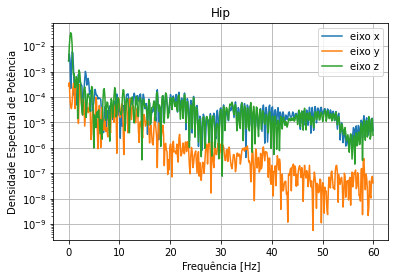

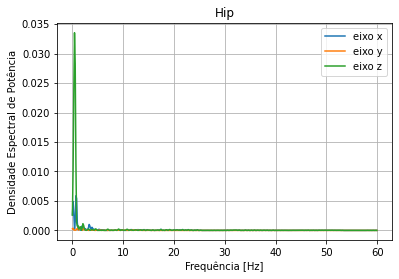

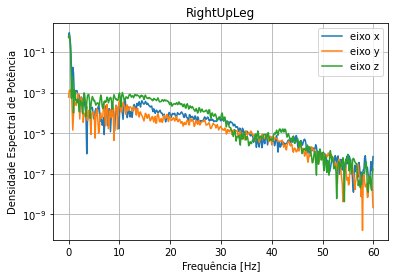

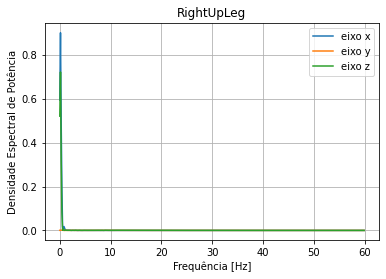

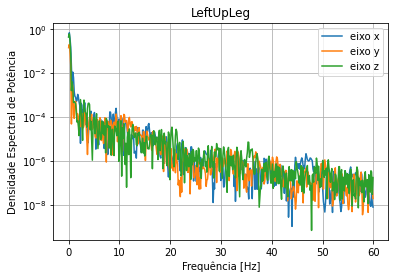

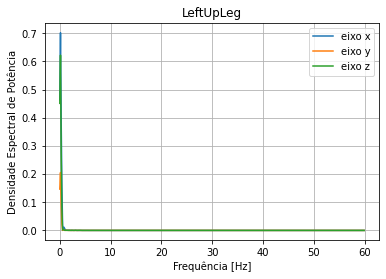

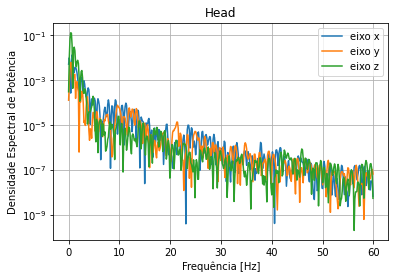

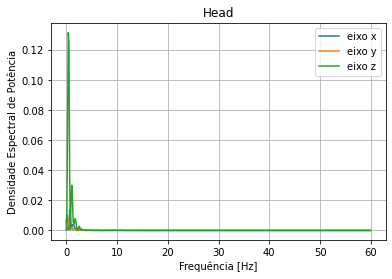

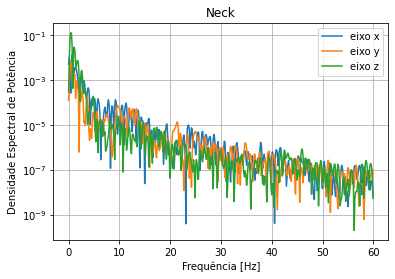

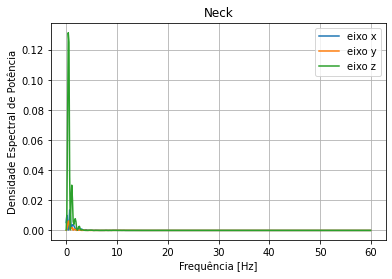

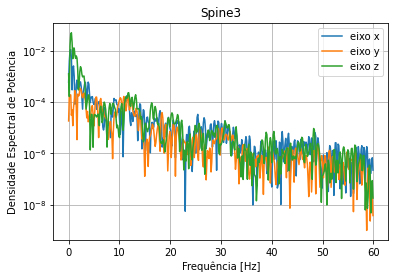

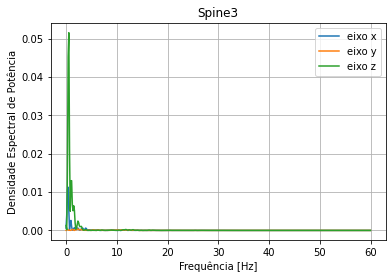

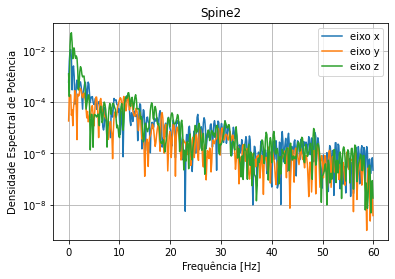

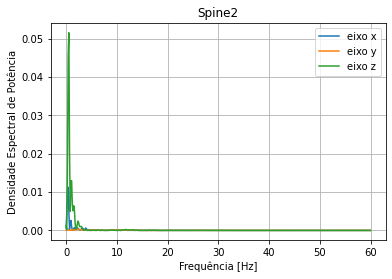

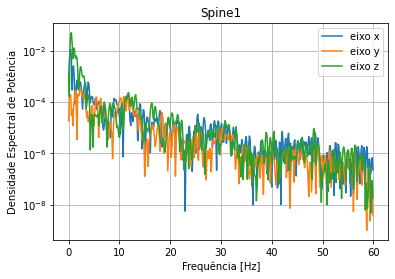

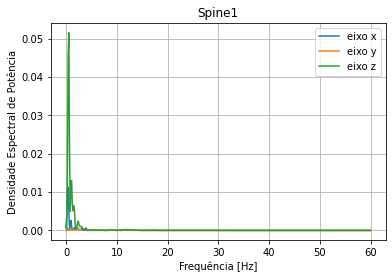

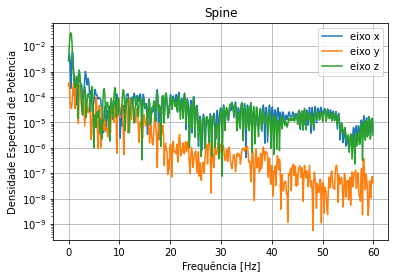

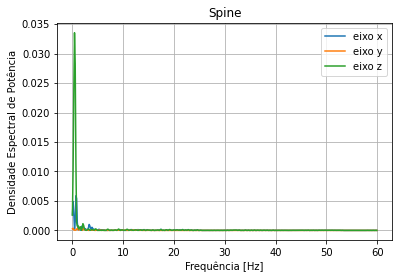

In [11]:
''' Substituir o número do dado para apresentar o espctro de todos os dados do voluntário'''
spectrum_periodogram_complete(data_5, freq_amostragem, grafico = 'pot_log')

### Separando os dados dos 5 exemplos para a perna direita

- Visualizar a densidade espectral de potência dos 5 exemplos
- Aplicar filtro com diferentes frequências de corte(0.5 Hz, 1 Hz, 2 Hz, 3 Hz) para os 5 exemplos
- Aplicar a conversão para angulo dos dados filtrados e não filtrados
- Visualizar a diferença de cada exemplo para as freqências de corte selecionadas em relação aos dados não filtrados

In [12]:
# Separar os dados da perna direita de cada voluntário
RightUpLeg_1 = data_1.iloc[:,3:6].values
RightUpLeg_2 = data_2.iloc[:,3:6].values
RightUpLeg_3 = data_3.iloc[:,3:6].values
RightUpLeg_4 = data_4.iloc[:,3:6].values
RightUpLeg_5 = data_5.iloc[:,3:6].values

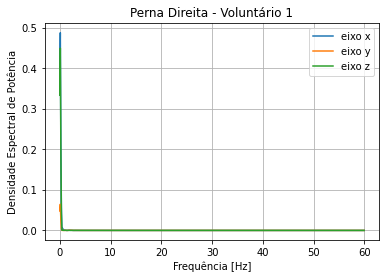

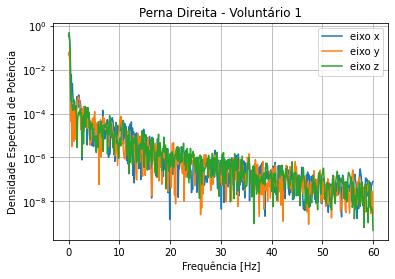

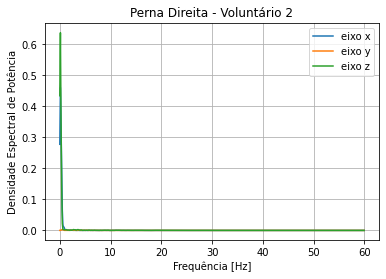

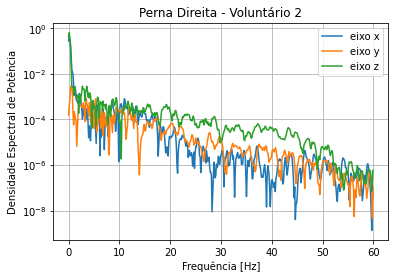

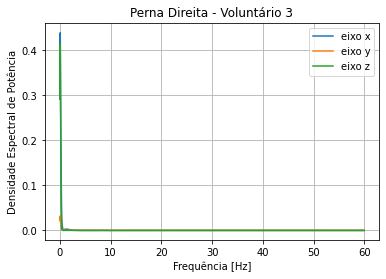

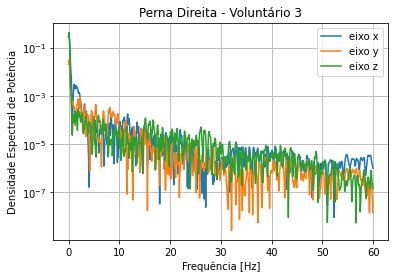

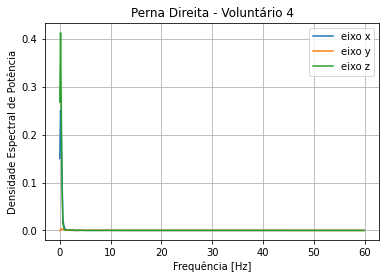

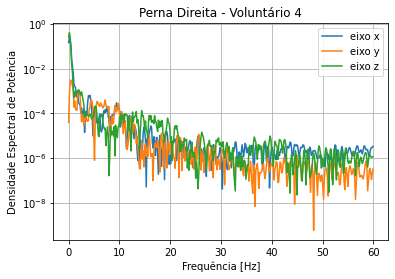

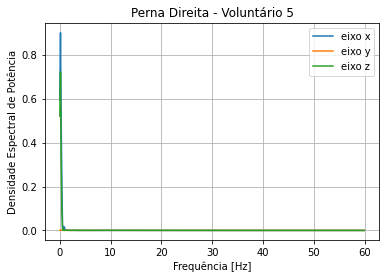

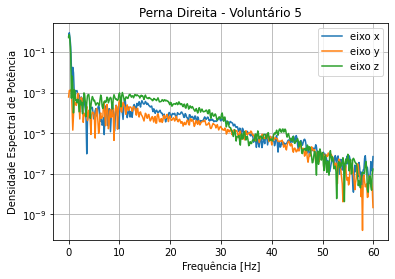

In [13]:
# Apresentar o Spectrograma de cada voluntário
spectrum_periodogram(RightUpLeg_1, freq_amostragem, title = 'Perna Direita - Voluntário 1')
spectrum_periodogram(RightUpLeg_2, freq_amostragem, title = 'Perna Direita - Voluntário 2')
spectrum_periodogram(RightUpLeg_3, freq_amostragem, title = 'Perna Direita - Voluntário 3')
spectrum_periodogram(RightUpLeg_4, freq_amostragem, title = 'Perna Direita - Voluntário 4')
spectrum_periodogram(RightUpLeg_5, freq_amostragem, title = 'Perna Direita - Voluntário 5')

Dessa forma, foi possível observar que a frequência que representa o sinal está entre 0 Hz e 5 Hz. 

Agora será aplicado os filtros selecionados para teste para os 5 sinais, em seguida será feita a conversão para ângulo e a apresentação dos dados em comparação com os dados não filtrados. 

In [30]:
# Definindo a ordem do filtro 
ordem = 2


# Aplicando filtro com frequência de corte em 0.5 Hz para as 5 amostras
RightUpLeg_1_filter_05Hz = filter_butter(RightUpLeg_1, ordem, 0.5, freq_amostragem)
RightUpLeg_2_filter_05Hz = filter_butter(RightUpLeg_2, ordem, 0.5, freq_amostragem)
RightUpLeg_3_filter_05Hz = filter_butter(RightUpLeg_3, ordem, 0.5, freq_amostragem)
RightUpLeg_4_filter_05Hz = filter_butter(RightUpLeg_4, ordem, 0.5, freq_amostragem)
RightUpLeg_5_filter_05Hz = filter_butter(RightUpLeg_5, ordem, 0.5, freq_amostragem)

# Aplicando filtro com frequência de corte em 1 Hz para as 5 amostras
RightUpLeg_1_filter_1Hz = filter_butter(RightUpLeg_1, ordem, 1, freq_amostragem)
RightUpLeg_2_filter_1Hz = filter_butter(RightUpLeg_2, ordem, 1, freq_amostragem)
RightUpLeg_3_filter_1Hz = filter_butter(RightUpLeg_3, ordem, 1, freq_amostragem)
RightUpLeg_4_filter_1Hz = filter_butter(RightUpLeg_4, ordem, 1, freq_amostragem)
RightUpLeg_5_filter_1Hz = filter_butter(RightUpLeg_5, ordem, 1, freq_amostragem)

# Aplicando filtro com frequência de corte em 2 Hz para as 5 amostras
RightUpLeg_1_filter_2Hz = filter_butter(RightUpLeg_1, ordem, 2, freq_amostragem)
RightUpLeg_2_filter_2Hz = filter_butter(RightUpLeg_2, ordem, 2, freq_amostragem)
RightUpLeg_3_filter_2Hz = filter_butter(RightUpLeg_3, ordem, 2, freq_amostragem)
RightUpLeg_4_filter_2Hz = filter_butter(RightUpLeg_4, ordem, 2, freq_amostragem)
RightUpLeg_5_filter_2Hz = filter_butter(RightUpLeg_5, ordem, 2, freq_amostragem)

# Aplicando filtro com frequência de corte em 3 Hz para as 5 amostras
RightUpLeg_1_filter_3Hz = filter_butter(RightUpLeg_1, ordem, 3, freq_amostragem)
RightUpLeg_2_filter_3Hz = filter_butter(RightUpLeg_2, ordem, 3, freq_amostragem)
RightUpLeg_3_filter_3Hz = filter_butter(RightUpLeg_3, ordem, 3, freq_amostragem)
RightUpLeg_4_filter_3Hz = filter_butter(RightUpLeg_4, ordem, 3, freq_amostragem)
RightUpLeg_5_filter_3Hz = filter_butter(RightUpLeg_5, ordem, 3, freq_amostragem)


Aplicando a conversão dos dados do acelerômetro para ângulos

In [31]:
# Aplicando a conversão dos dados de aceleração para ângulos.
angle_rad_RightUpLeg_1, angle_RightUpLeg_1 = acc_to_angle(RightUpLeg_1)
angle_rad_RightUpLeg_2, angle_RightUpLeg_2 = acc_to_angle(RightUpLeg_2)
angle_rad_RightUpLeg_3, angle_RightUpLeg_3 = acc_to_angle(RightUpLeg_3)
angle_rad_RightUpLeg_4, angle_RightUpLeg_4 = acc_to_angle(RightUpLeg_4)
angle_rad_RightUpLeg_5, angle_RightUpLeg_5 = acc_to_angle(RightUpLeg_5)

# Aplicando a conversão dos dados de aceleração filtrados em 0.5 Hz para ângulos.
angle_rad_RightUpLeg_1_filter_05Hz, angle_RightUpLeg_1_filter_05Hz = acc_to_angle(RightUpLeg_1_filter_05Hz)
angle_rad_RightUpLeg_2_filter_05Hz, angle_RightUpLeg_2_filter_05Hz = acc_to_angle(RightUpLeg_2_filter_05Hz)
angle_rad_RightUpLeg_3_filter_05Hz, angle_RightUpLeg_3_filter_05Hz = acc_to_angle(RightUpLeg_3_filter_05Hz)
angle_rad_RightUpLeg_4_filter_05Hz, angle_RightUpLeg_4_filter_05Hz = acc_to_angle(RightUpLeg_4_filter_05Hz)
angle_rad_RightUpLeg_5_filter_05Hz, angle_RightUpLeg_5_filter_05Hz = acc_to_angle(RightUpLeg_5_filter_05Hz)

# Aplicando a conversão dos dados de aceleração filtrados em 10 Hz para ângulos.
angle_rad_RightUpLeg_1_filter_1Hz, angle_RightUpLeg_1_filter_1Hz = acc_to_angle(RightUpLeg_1_filter_1Hz)
angle_rad_RightUpLeg_2_filter_1Hz, angle_RightUpLeg_2_filter_1Hz = acc_to_angle(RightUpLeg_2_filter_1Hz)
angle_rad_RightUpLeg_3_filter_1Hz, angle_RightUpLeg_3_filter_1Hz = acc_to_angle(RightUpLeg_3_filter_1Hz)
angle_rad_RightUpLeg_4_filter_1Hz, angle_RightUpLeg_4_filter_1Hz = acc_to_angle(RightUpLeg_4_filter_1Hz)
angle_rad_RightUpLeg_5_filter_1Hz, angle_RightUpLeg_5_filter_1Hz = acc_to_angle(RightUpLeg_5_filter_1Hz)

# Aplicando a conversão dos dados de aceleração filtrados em 2 Hz para ângulos.
angle_rad_RightUpLeg_1_filter_2Hz, angle_RightUpLeg_1_filter_2Hz = acc_to_angle(RightUpLeg_1_filter_2Hz)
angle_rad_RightUpLeg_2_filter_2Hz, angle_RightUpLeg_2_filter_2Hz = acc_to_angle(RightUpLeg_2_filter_2Hz)
angle_rad_RightUpLeg_3_filter_2Hz, angle_RightUpLeg_3_filter_2Hz = acc_to_angle(RightUpLeg_3_filter_2Hz)
angle_rad_RightUpLeg_4_filter_2Hz, angle_RightUpLeg_4_filter_2Hz = acc_to_angle(RightUpLeg_4_filter_2Hz)
angle_rad_RightUpLeg_5_filter_2Hz, angle_RightUpLeg_5_filter_2Hz = acc_to_angle(RightUpLeg_5_filter_2Hz)

# Aplicando a conversão dos dados de aceleração filtrados em 3 Hz para ângulos.
angle_rad_RightUpLeg_1_filter_3Hz, angle_RightUpLeg_1_filter_3Hz = acc_to_angle(RightUpLeg_1_filter_3Hz)
angle_rad_RightUpLeg_2_filter_3Hz, angle_RightUpLeg_2_filter_3Hz = acc_to_angle(RightUpLeg_2_filter_3Hz)
angle_rad_RightUpLeg_3_filter_3Hz, angle_RightUpLeg_3_filter_3Hz = acc_to_angle(RightUpLeg_3_filter_3Hz)
angle_rad_RightUpLeg_4_filter_3Hz, angle_RightUpLeg_4_filter_3Hz = acc_to_angle(RightUpLeg_4_filter_3Hz)
angle_rad_RightUpLeg_5_filter_3Hz, angle_RightUpLeg_5_filter_3Hz = acc_to_angle(RightUpLeg_5_filter_3Hz)


In [32]:
# Criando vetor de tempo
t_right_up_leg_1 = np.linspace(0, len(angle_RightUpLeg_1) / freq_amostragem, len(angle_RightUpLeg_1))
t_right_up_leg_2 = np.linspace(0, len(angle_RightUpLeg_2) / freq_amostragem, len(angle_RightUpLeg_2))
t_right_up_leg_3 = np.linspace(0, len(angle_RightUpLeg_3) / freq_amostragem, len(angle_RightUpLeg_3))
t_right_up_leg_4 = np.linspace(0, len(angle_RightUpLeg_4) / freq_amostragem, len(angle_RightUpLeg_4))
t_right_up_leg_5 = np.linspace(0, len(angle_RightUpLeg_5) / freq_amostragem, len(angle_RightUpLeg_5))

## Apresentação das respostas para os dados de 5 voluntários com a aplicação de 4 filtros com frequências de cortes diferentes

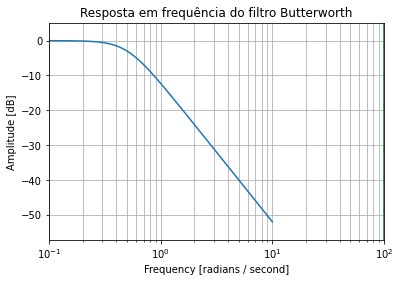

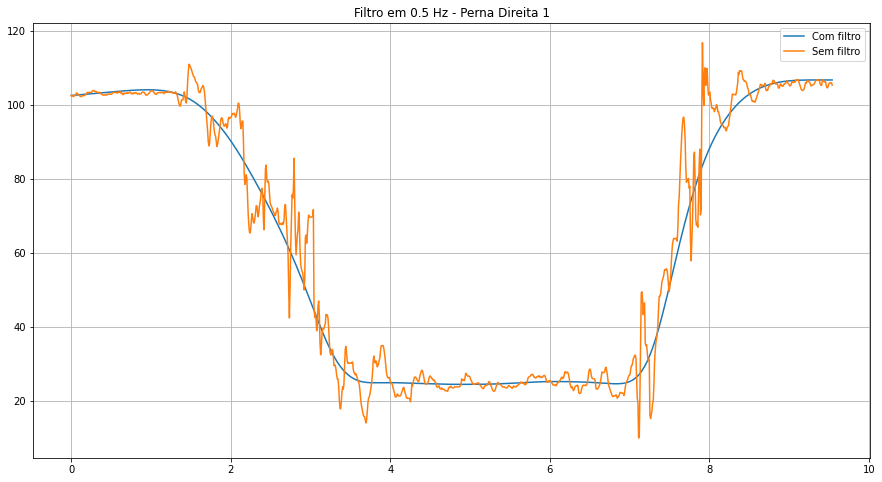

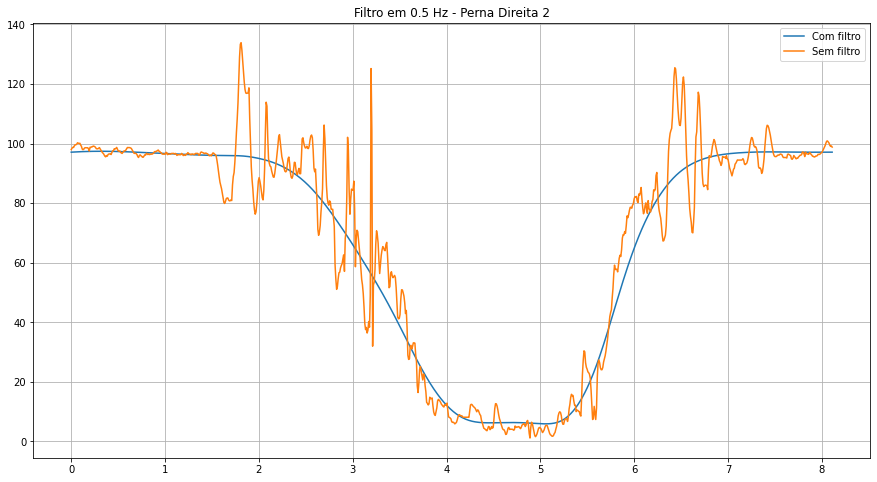

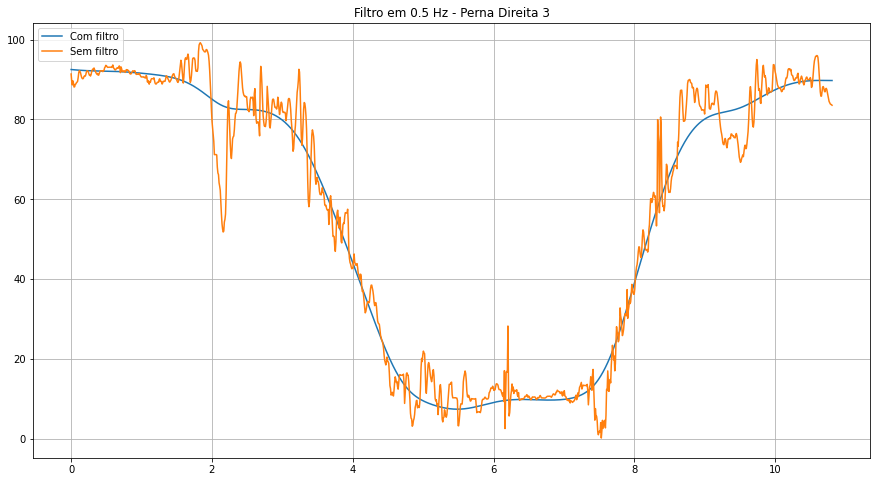

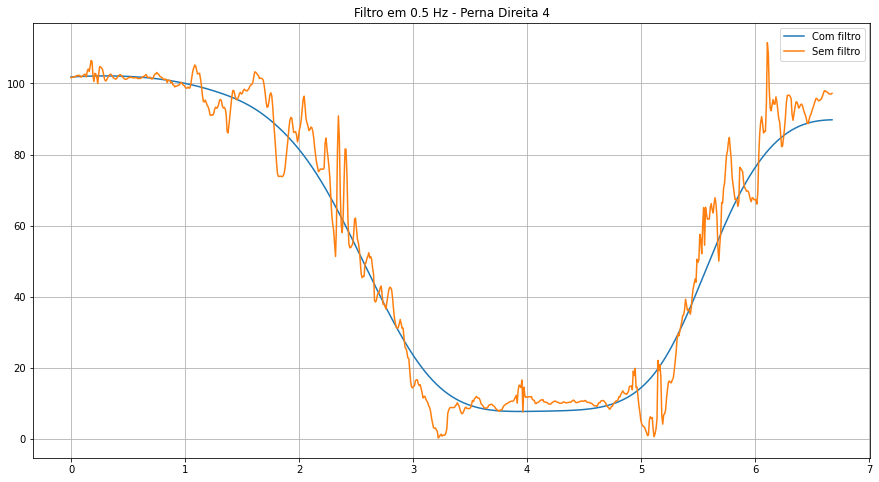

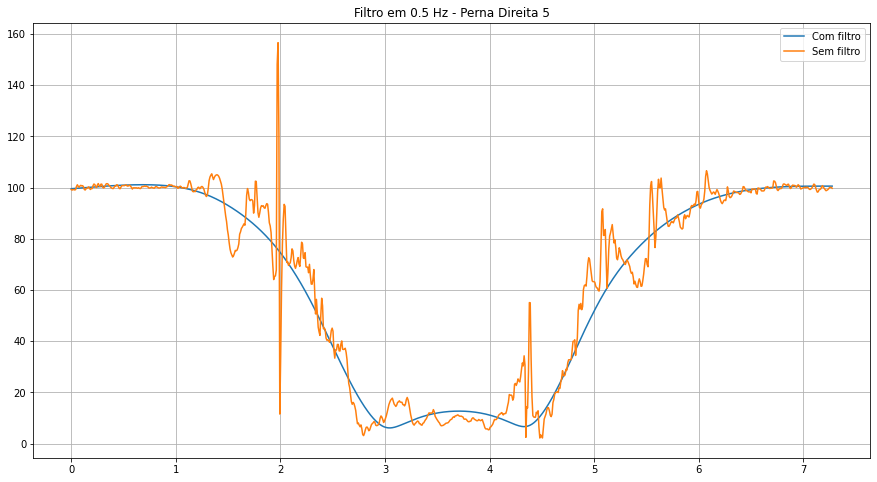

In [33]:
# Aplicando o filtro e apresentado os dados comparando com os dados originais
# 0.5 Hz
plot_filter_butter(ordem, 0.5)
plot_comp_filter(t_right_up_leg_1, angle_RightUpLeg_1, angle_RightUpLeg_1_filter_05Hz, title='Filtro em 0.5 Hz - Perna Direita 1')
plot_comp_filter(t_right_up_leg_2, angle_RightUpLeg_2, angle_RightUpLeg_2_filter_05Hz, title='Filtro em 0.5 Hz - Perna Direita 2')
plot_comp_filter(t_right_up_leg_3, angle_RightUpLeg_3, angle_RightUpLeg_3_filter_05Hz, title='Filtro em 0.5 Hz - Perna Direita 3')
plot_comp_filter(t_right_up_leg_4, angle_RightUpLeg_4, angle_RightUpLeg_4_filter_05Hz, title='Filtro em 0.5 Hz - Perna Direita 4')
plot_comp_filter(t_right_up_leg_5, angle_RightUpLeg_5, angle_RightUpLeg_5_filter_05Hz, title='Filtro em 0.5 Hz - Perna Direita 5')

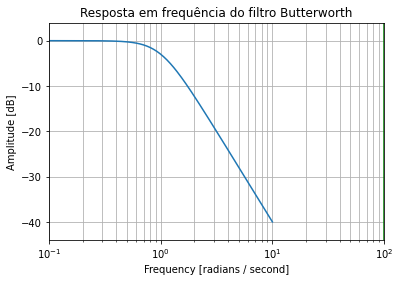

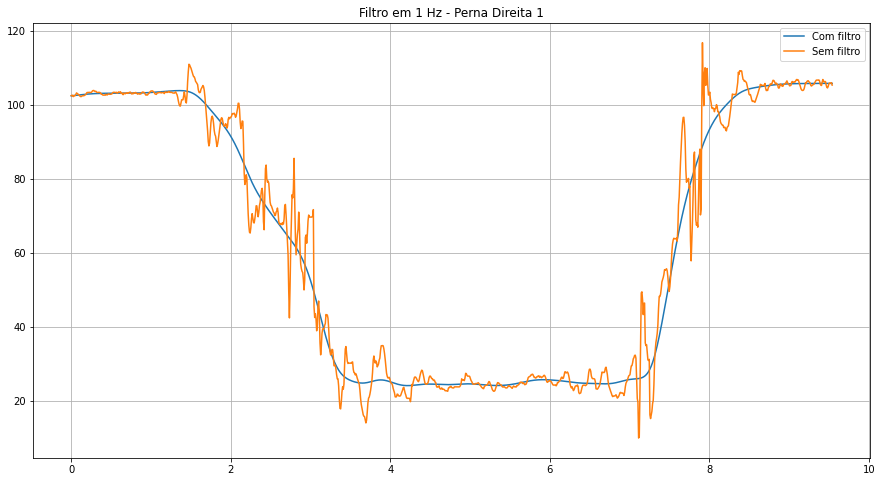

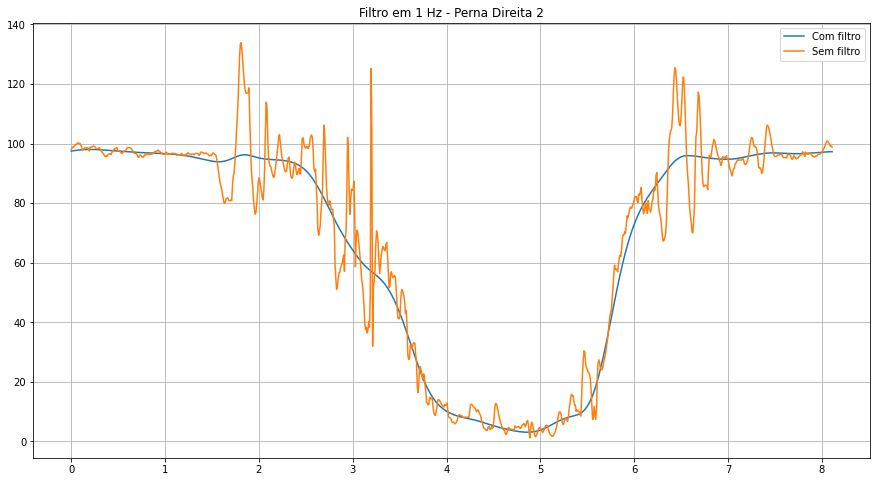

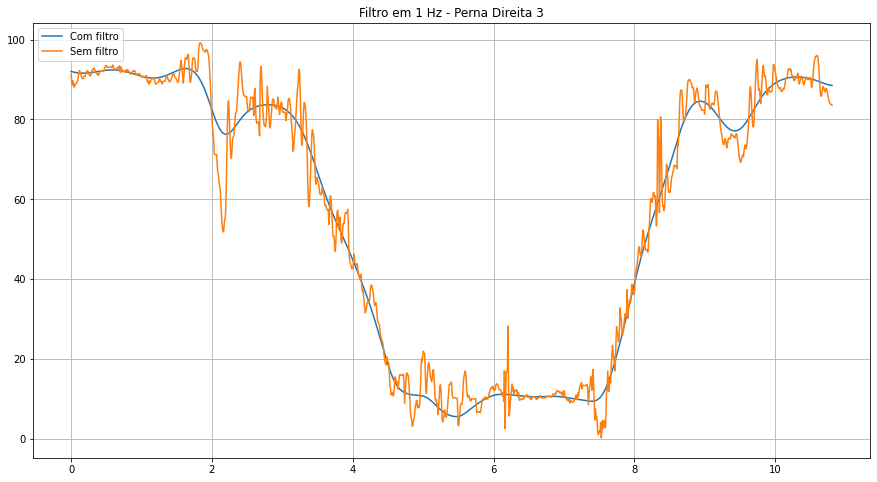

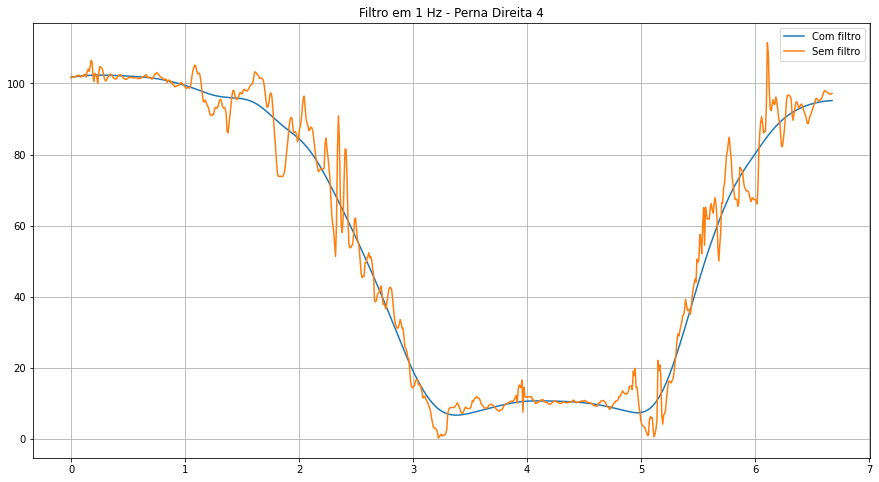

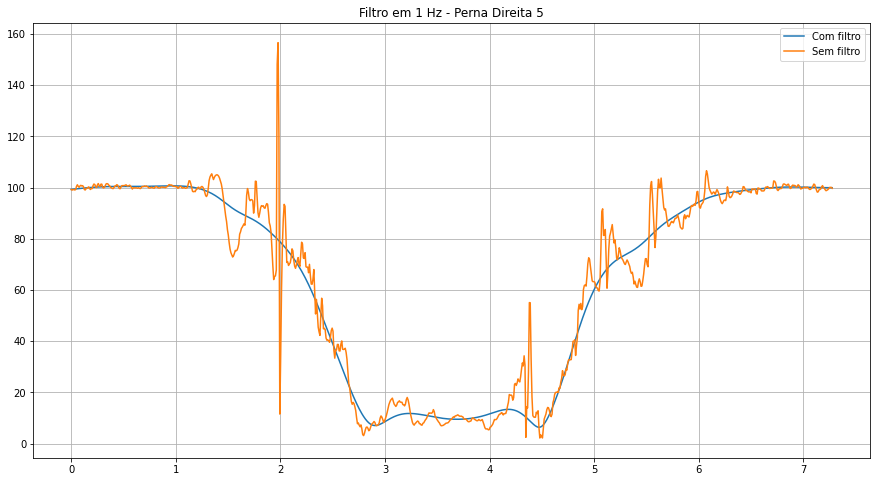

In [17]:
# Aplicando o filtro e apresentado os dados comparando com os dados originais
# 1 Hz
plot_filter_butter(ordem, 1)
plot_comp_filter(t_right_up_leg_1, angle_RightUpLeg_1, angle_RightUpLeg_1_filter_1Hz, title='Filtro em 1 Hz - Perna Direita 1')
plot_comp_filter(t_right_up_leg_2, angle_RightUpLeg_2, angle_RightUpLeg_2_filter_1Hz, title='Filtro em 1 Hz - Perna Direita 2')
plot_comp_filter(t_right_up_leg_3, angle_RightUpLeg_3, angle_RightUpLeg_3_filter_1Hz, title='Filtro em 1 Hz - Perna Direita 3')
plot_comp_filter(t_right_up_leg_4, angle_RightUpLeg_4, angle_RightUpLeg_4_filter_1Hz, title='Filtro em 1 Hz - Perna Direita 4')
plot_comp_filter(t_right_up_leg_5, angle_RightUpLeg_5, angle_RightUpLeg_5_filter_1Hz, title='Filtro em 1 Hz - Perna Direita 5')

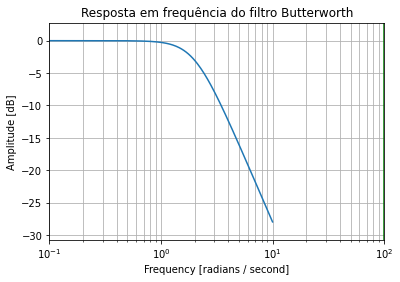

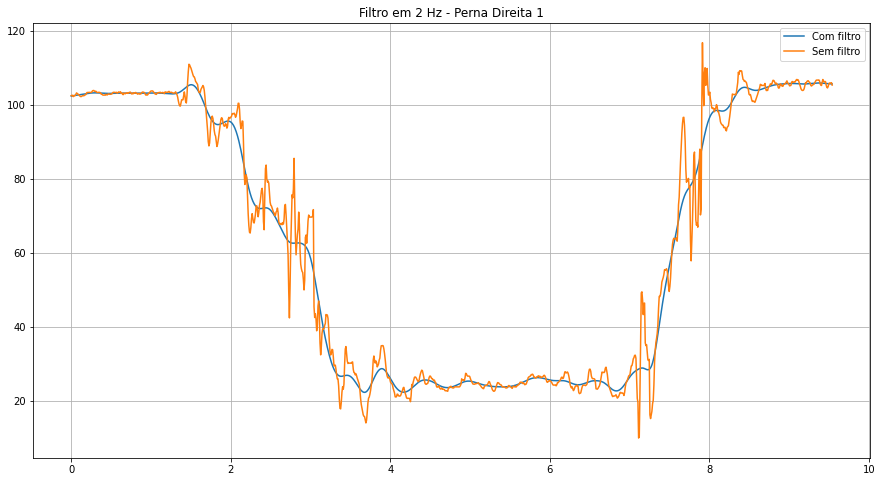

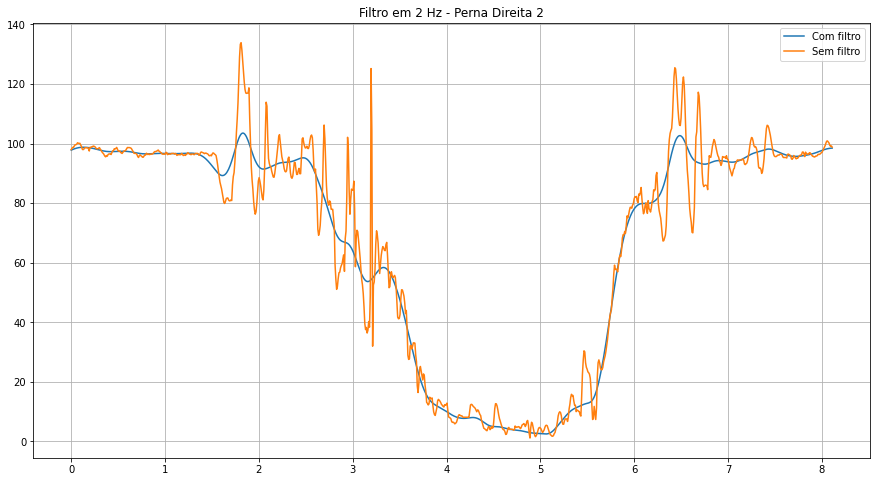

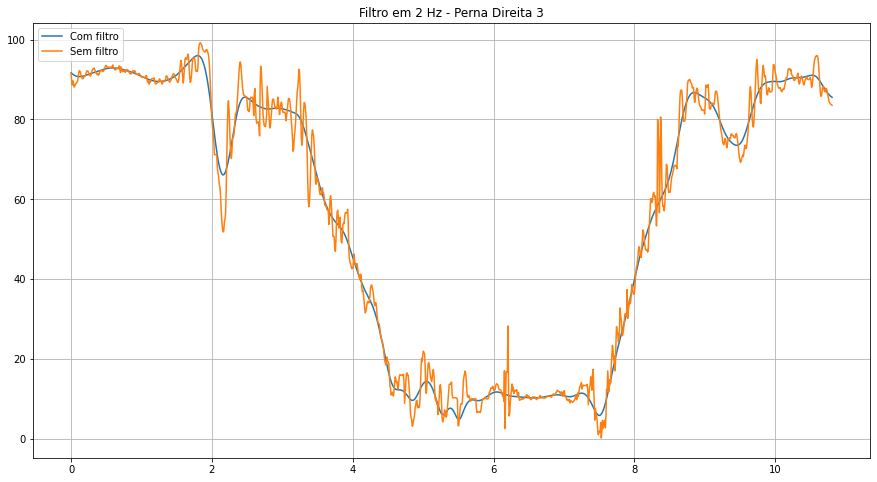

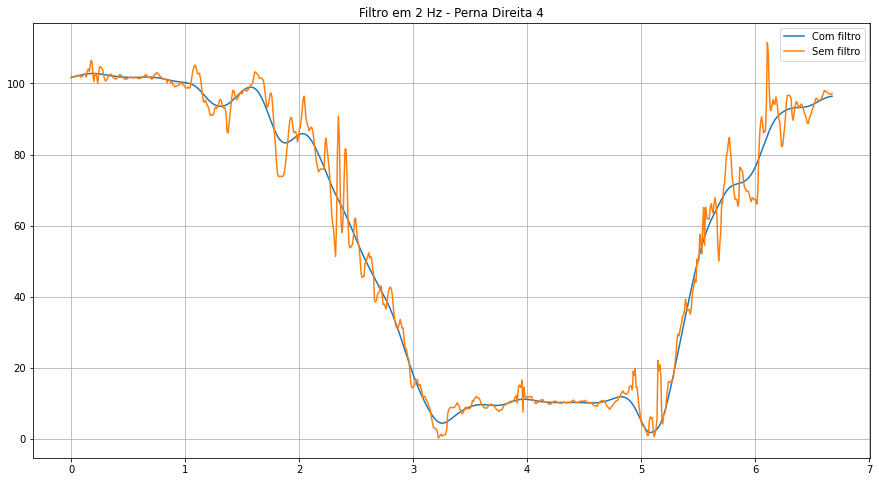

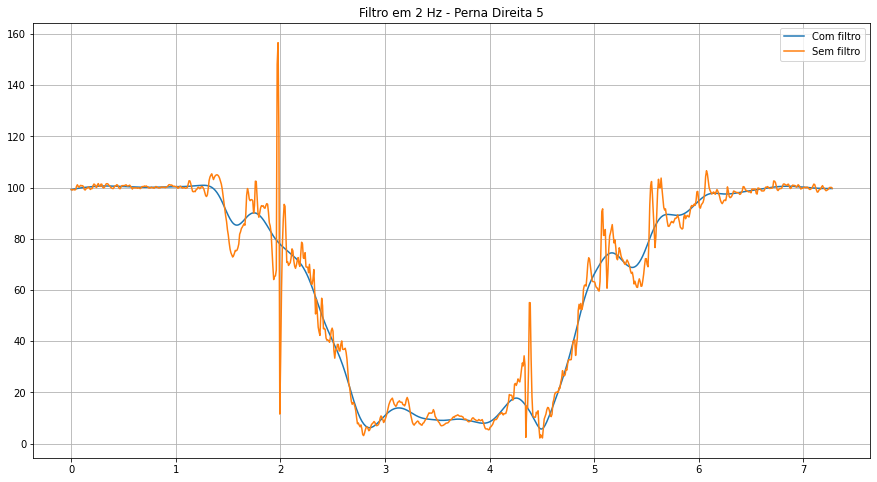

In [18]:
# Aplicando o filtro e apresentado os dados comparando com os dados originais
# 2 Hz
plot_filter_butter(ordem, 2)
plot_comp_filter(t_right_up_leg_1, angle_RightUpLeg_1, angle_RightUpLeg_1_filter_2Hz, title='Filtro em 2 Hz - Perna Direita 1')
plot_comp_filter(t_right_up_leg_2, angle_RightUpLeg_2, angle_RightUpLeg_2_filter_2Hz, title='Filtro em 2 Hz - Perna Direita 2')
plot_comp_filter(t_right_up_leg_3, angle_RightUpLeg_3, angle_RightUpLeg_3_filter_2Hz, title='Filtro em 2 Hz - Perna Direita 3')
plot_comp_filter(t_right_up_leg_4, angle_RightUpLeg_4, angle_RightUpLeg_4_filter_2Hz, title='Filtro em 2 Hz - Perna Direita 4')
plot_comp_filter(t_right_up_leg_5, angle_RightUpLeg_5, angle_RightUpLeg_5_filter_2Hz, title='Filtro em 2 Hz - Perna Direita 5')

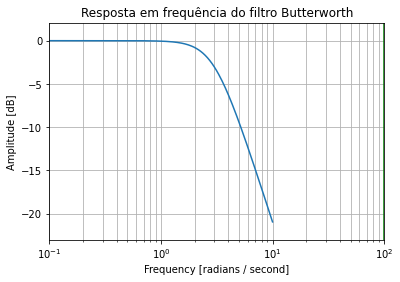

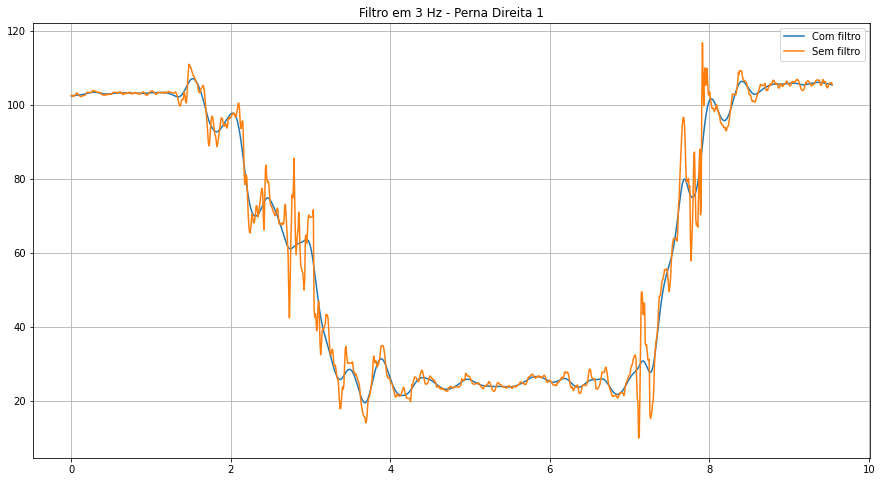

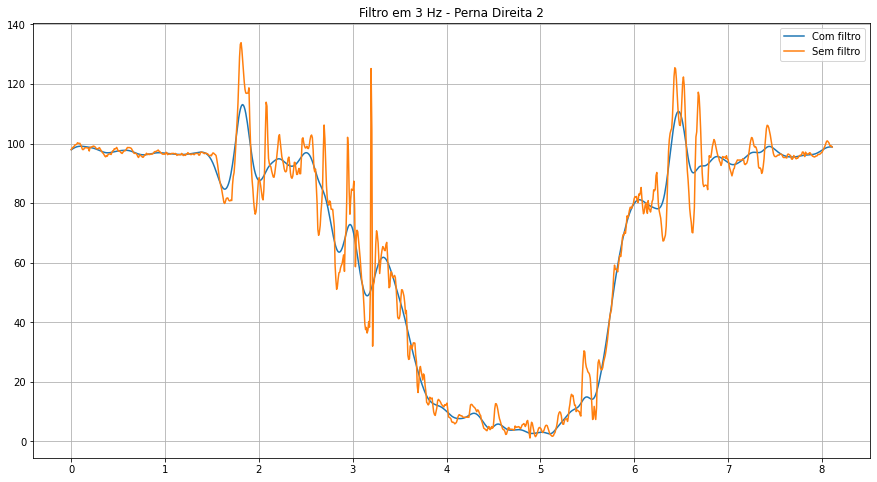

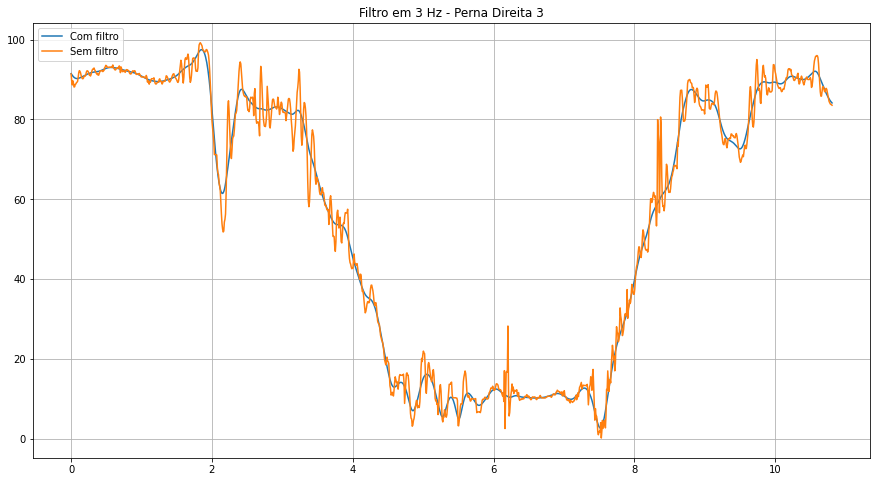

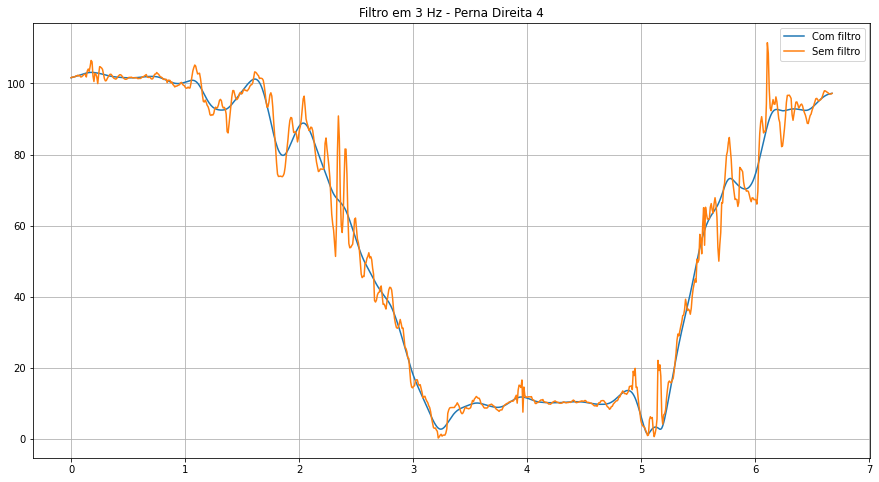

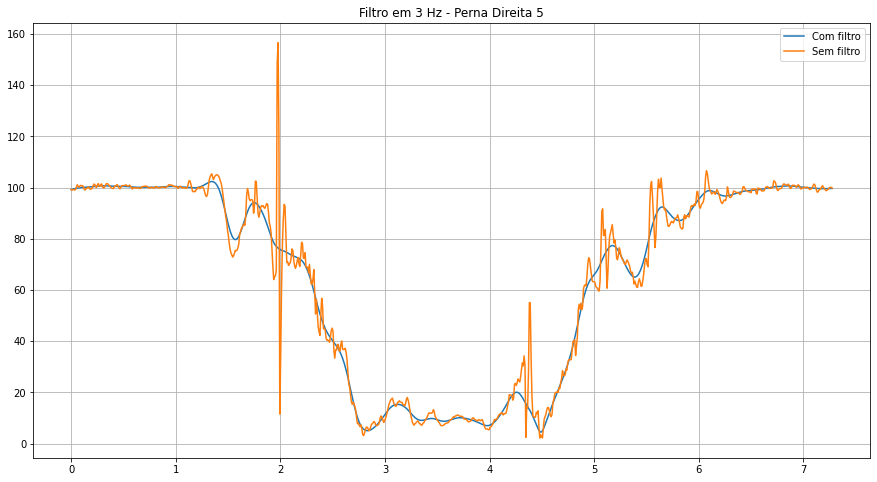

In [19]:
# Aplicando o filtro e apresentado os dados comparando com os dados originais
# 3 Hz
plot_filter_butter(ordem, 3)
plot_comp_filter(t_right_up_leg_1, angle_RightUpLeg_1, angle_RightUpLeg_1_filter_3Hz, title='Filtro em 3 Hz - Perna Direita 1')
plot_comp_filter(t_right_up_leg_2, angle_RightUpLeg_2, angle_RightUpLeg_2_filter_3Hz, title='Filtro em 3 Hz - Perna Direita 2')
plot_comp_filter(t_right_up_leg_3, angle_RightUpLeg_3, angle_RightUpLeg_3_filter_3Hz, title='Filtro em 3 Hz - Perna Direita 3')
plot_comp_filter(t_right_up_leg_4, angle_RightUpLeg_4, angle_RightUpLeg_4_filter_3Hz, title='Filtro em 3 Hz - Perna Direita 4')
plot_comp_filter(t_right_up_leg_5, angle_RightUpLeg_5, angle_RightUpLeg_5_filter_3Hz, title='Filtro em 3 Hz - Perna Direita 5')